Colorspace and architecture: https://arxiv.org/abs/2204.02850  
Fully Convolutional Networks: https://arxiv.org/pdf/1411.4038.pdf

Jetson nano: 0.236 TFLOPS fp32

Image colorization on youtube: https://youtu.be/WXyeQeHUxpc?si=jQfcU8Ra4StxFOwT

Youtube code: https://colab.research.google.com/drive/1BsqM7GBTtsyBixy2jsLGJNiSvp1ocpV7?usp=sharing


In [ ]:
% pip install torchprofile 1>/dev/null
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs # Helps us to obtain mac calculations

import torch.nn.functional as F
import os
from torch.utils.data import Dataset
from PIL import Image

print("Testing if GPU is available.")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, Falling back to CPU.")

os.chdir("/home/aaron/git/ImageColorization/")
BASEADDR = os.getcwd()
print(f"Current working directory: {BASEADDR}")

BATCH_SIZE = 64


UsageError: Line magic function `%` not found.


# Download and unpack imagenet64 database
imagenet64 is the imagenet database with each image scaled to be 64 by 64 pixels.

In [ ]:

checkpoints = f"{BASEADDR}/checkpoints/"
content = f"{BASEADDR}/content/"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

import shutil
if not os.path.exists(content):
    os.makedirs(content)
if not os.path.exists(f'{content}/imagenet64'):
  os.chdir(content)
  if not os.path.exists(content + 'imagenet64.tar'):
    print("Downloading archive...")
    !wget https://pjreddie.com/media/files/imagenet64.tar
  print("Uncompressing...")
  !tar -xf imagenet64.tar

print("Data ready!")

Data ready!


In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load color image
        color_img, _ = self.dataset[idx]

        # Convert color image to grayscale
        gray = transforms.Grayscale()
        grayscale_img = gray(color_img)

        return grayscale_img, color_img


In [ ]:
def get_imagenet64_data():
  ## transformations
  ##transform = transforms.Compose(
    ##  [transforms.Resize(64), transforms.RandomHorizontalFlip(), transforms.ToTensor().to(device)])

  transform=transforms.Compose([
                             transforms.RandomResizedCrop(64, scale=(1.0, 1.0), ratio=(1., 1.)),
                              transforms.RandomHorizontalFlip(),
                              #transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ])

  ## download and load training dataset
  trainSet = torchvision.datasets.ImageFolder(root=f'{content}/imagenet64/train/', transform=transform)
  # subset = 500 # Delete this line after debug
  # trainSet, _ = torch.utils.data.random_split(trainSet, [subset, len(trainSet)-subset]) # Delete this line after debug
  colorizationTrainSet = ColorizationDataset(trainSet)
  trainLoader = DataLoader(colorizationTrainSet, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

  ## download and load testing dataset
  testSet = torchvision.datasets.ImageFolder(root=f'{content}/imagenet64/val/', transform=transform)
  # testSet, _ = torch.utils.data.random_split(testSet, [subset, len(testSet)-subset]) # Delete this line after debug
  colorizationTestSet = ColorizationDataset(testSet)
  testloader = torch.utils.data.DataLoader(colorizationTestSet, batch_size=128, shuffle=False, num_workers=0)
  return {'train': trainLoader, 'test': testloader}

In [ ]:
from cycler import concat
class GrayNet(nn.Module):
    def __init__(self):
        super(GrayNet, self).__init__()
        channels = 16
        #block 1
        self.conv1 = nn.Conv2d(1, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)

        #block 2
        self.conv3 = nn.Conv2d(channels, channels*2, 3, padding=1)
        self.conv4 = nn.Conv2d(channels*2, channels*2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels*2)
        self.bn4 = nn.BatchNorm2d(channels*2)

        #block 3
        self.conv5 = nn.Conv2d(channels*2, channels*4, 3, padding=1)
        self.conv6 = nn.Conv2d(channels*4, channels*4, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(channels*4)
        self.bn6 = nn.BatchNorm2d(channels*4)

        #block 4
        self.conv7 = nn.Conv2d(channels*4, channels*8, 3, padding=1)
        self.conv8 = nn.Conv2d(channels*8, channels*8, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(channels*8)
        self.bn8 = nn.BatchNorm2d(channels*8)

        #block 5
        self.conv9 = nn.Conv2d(channels*8, channels*8, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(channels*8)
        self.conv10 = nn.ConvTranspose2d(channels*8,channels*8, kernel_size=2,stride=2)

        #block 6
        self.conv11 = nn.Conv2d(channels*16, channels*8, 3, padding=1)
        self.conv12 = nn.Conv2d(channels*8, channels*4, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(channels*8)
        self.bn12 = nn.BatchNorm2d(channels*4)
        self.conv13 = nn.ConvTranspose2d(channels*4,channels*4, kernel_size=2,stride=2)

        #block 7
        self.conv14 = nn.Conv2d(channels*8, channels*4, 3, padding=1)
        self.conv15 = nn.Conv2d(channels*4, channels*2, 3, padding=1)
        self.bn14 = nn.BatchNorm2d(channels*4)
        self.bn15 = nn.BatchNorm2d(channels*2)
        self.conv16 = nn.ConvTranspose2d(channels*2,channels*2, kernel_size=2,stride=2)

        #block 8
        self.conv17 = nn.Conv2d(channels*4, channels*2, 3, padding=1)
        self.conv18 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.bn17 = nn.BatchNorm2d(channels*2)
        self.bn18 = nn.BatchNorm2d(channels)
        self.conv19 = nn.ConvTranspose2d(channels,channels, kernel_size=2,stride=2)

        #block 9
        self.conv20 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv21 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv22 = nn.Conv2d(channels, 3, 3, padding=1)
        self.bn20 = nn.BatchNorm2d(channels)
        self.bn21 = nn.BatchNorm2d(channels)
        self.bn22 = nn.BatchNorm2d(3)

    def forward(self, x):
        #print(x.size())
        # Input 64x64x1
        #block1
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))) # 32x32xchannels
        block1 = x
        x = F.max_pool2d(x,2)
        #print(x.size())
        x = F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))) # 16x16xchannels*2
        block2 = x
        x = F.max_pool2d(x,2)
        #print(x.size())
        x = F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(x)))))) # 8x8xchannels*4
        block3 = x
        x = F.max_pool2d(x,2)
        #print(x.size())
        x = F.relu(self.bn8(self.conv8(F.relu(self.bn7(self.conv7(x)))))) # 4x4xchannels*8
        block4 = x
        x = F.max_pool2d(x,2)
        #print(x.size())

        x = self.conv10(F.relu(self.bn9(self.conv9(x)))) # 8x8xchannels*8
        #print(x.size())

        x = torch.cat((x,block4),1) #8x8xchannels*16
        x = self.conv13(F.relu(self.bn12(self.conv12(F.relu(self.bn11(self.conv11(x))))))) #16x16xchannels*4
        #print(x.size())

        x =torch.cat((x,block3),1)#16x16xchannels*8
        x = self.conv16(F.relu(self.bn15(self.conv15(F.relu(self.bn14(self.conv14(x))))))) #32x32xchannels*2
        #print(x.size())

        x =torch.cat((x,block2),1) #32x32xchannels*4
        x = self.conv19(F.relu(self.bn18(self.conv18(F.relu(self.bn17(self.conv17(x))))))) #64x64xchannels
        #print(x.size())

        x = F.relu(self.bn22(self.conv22(F.relu(self.bn21(self.conv21(F.relu(self.bn20(self.conv20(x))))))))) #64x64x3
        #print(x.size())

        return x


### Test network sizes.

In [ ]:
testInput = torch.randn(1,1,64,64).to(device)

testNetwork = GrayNet().to(device)
testNetwork(testInput)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5165, 1.5856, 0.0000,  ..., 0.1990, 0.0000, 0.0000],
          [0.0000, 0.0115, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1404, 0.0000, 0.0000,  ..., 1.2869, 0.0000, 0.0000],
          [0.7047, 0.1029, 0.9841,  ..., 0.3250, 0.0000, 0.0106],
          [0.8590, 0.0000, 0.3971,  ..., 0.2833, 0.3380, 0.0000]],

         [[0.2624, 1.0336, 0.6836,  ..., 1.8106, 0.7055, 0.0000],
          [0.0000, 0.2517, 0.8226,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4855,  ..., 0.7221, 1.1734, 0.6865],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.7209, 0.0000, 0.0000],
          [0.0000, 0.4070, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4367, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1016],
          [0.0000, 0.0000, 2.1498,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

### Get the networks MACs and size.

In [ ]:
#Model size
def get_model_macs(model, inputs) -> int:
  # We iimported profile_macs in the necessary packages loaded
    return profile_macs(model, inputs)

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB


In [ ]:
model_size = get_model_size(testNetwork)
print(f"model has size={model_size/MiB:.2f} MiB")
macs = get_model_macs(testNetwork,testInput)
latency = (macs*2)/(0.236*10**12)
fps = latency**-1
print(macs)
print(latency)
print(fps)


model has size=3.89 MiB
163530752
0.0013858538305084745
721.5768199977458


In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: StepLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  # Update scheduler
  scheduler.step()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  verbose=True,
) -> float:
  model.eval()

  loss = 0

  for inputs, targets in tqdm(dataloader, leave=False, disable= not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    loss += criterion(outputs, targets).item()

  return loss

# Initialize model and dataset

In [ ]:
model = GrayNet().to(device)

data = get_imagenet64_data()
trainLoader = data['train']#enumerate(data['train'])#iter(data['train'])
testLoader = data['test']#enumerate(data['test'])#iter(data['test'])

### Save model to file

In [ ]:
# Save current model to file
def saveModel(state, savePath):
    if not os.path.exists(os.path.dirname(savePath)):
        os.makedirs(os.path.dirname(savePath))
    torch.save(state, savePath)

saveModel(model.state_dict(), f"{checkpoints}baseline.pt")

### Load existing model

In [ ]:
# Load model from file.
loadPath = f"{checkpoints}FirstNetwork.pt"
model.load_state_dict(torch.load(loadPath))
recover_model = lambda: model.load_state_dict(torch.load(loadPath))

### Visualize the data fed into the network

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

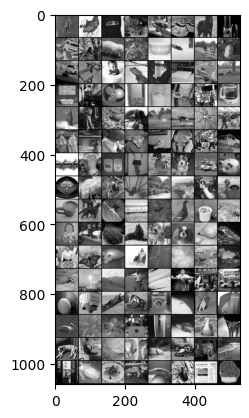

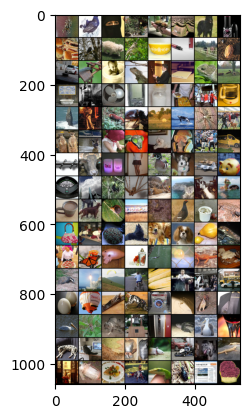

In [ ]:
def visualizeData(dataLoader: DataLoader):
    inputs, targets = next(iter(dataLoader))

    # show grayscale images.
    imshow(torchvision.utils.make_grid(inputs))
    
    # show original images.
    imshow(torchvision.utils.make_grid(targets))

visualizeData(trainLoader)

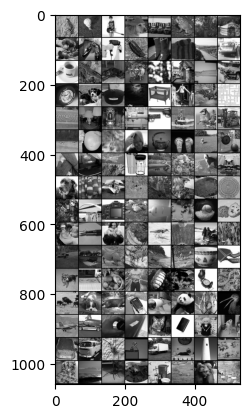

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


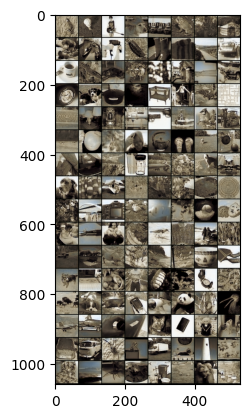

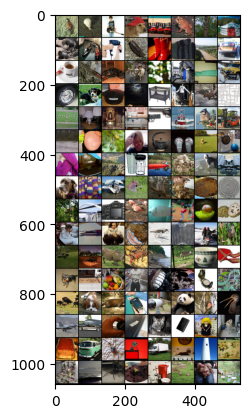

In [ ]:
def visualizeNetwork(model: nn.Module, dataLoader: DataLoader):
    inputs, targets = next(iter(dataLoader))

    # show grayscale images.
    imshow(torchvision.utils.make_grid(inputs))

    # show colorized images.
    outputs = model(inputs.to(device))
    imshow(torchvision.utils.make_grid(outputs.cpu()))
    
    # show original images.
    imshow(torchvision.utils.make_grid(targets))

visualizeNetwork(model, trainLoader)

### Train the network.

In [518]:
VERSION = 0

lr = 0.1
lr_step_gamma = 0.8
num_epochs = 20

optimizer = Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 10000


for epoch in range(num_epochs):
    train(model, trainLoader, criterion, optimizer, scheduler)
    accuracy = evaluate(model, testLoader, criterion)
    if accuracy < best_accuracy:
        saveModel(model.state_dict(), f"{checkpoints}{VERSION}/{epoch}.pt")
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy} / Best Accuracy: {best_accuracy}')

  0%|          | 0/10010 [00:00<?, ?it/s]

KeyboardInterrupt: 